# Importance Sampling for OTM Option

Importance sampling is a technique used in statistics and Monte Carlo simulations to improve the efficiency of estimating rare events or computing integrals involving probability distributions. It is particularly useful when the standard Monte Carlo methods would require a large number of samples to obtain accurate results.

Importance sampling can be utilized in the context of OTM (Out of the Money) options to improve the efficiency of estimating certain option-related quantities or conducting simulations involving these options. In this case, it is particularly interesting because it may decrease the variance of Monte Carlo Options Calculation.

Under Risk-Neutral Pricing, a European Call Option has a closed form solution(BS), but also has

$E_Q[e^{-rT}(S_0e^{Z_T}-K)^+]$, where $Z_T \sim N((r-\frac{\sigma^2}{2})T, \sigma^2T)$

In [30]:
import numpy as np
import pandas as pd
import scipy as sc
from scipy import stats
import matplotlib.pyplot as plt
plt.style.use('dark_background')

import warnings
warnings.filterwarnings("ignore")

In [31]:
def BS(r, S, K, T, sigma, opt_type="C"):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    try:
        if opt_type == "C":
            price = S*sc.stats.norm.cdf(d1, 0, 1) - K*np.exp(-r*T)*sc.stats.norm.cdf(d2, 0, 1)
        elif opt_type == "P":
            price = K*np.exp(-r*T)*sc.stats.norm.cdf(-d2, 0, 1) - S*sc.stats.norm.cdf(-d1, 0, 1)
        return price
    except:
        print("Confirm 'C'all or 'P'ut Option")

In [32]:
S0 = 100.0     
K = 170.0      
T = 1.0        
r = 0.06       
vol = 0.20     

dt = T
nudt = (r - 0.5*vol**2)*dt
nudt2 = (np.log(K/S0)-0.5*vol**2)*dt
volsdt = vol*np.sqrt(dt)

black_scholes = BS(r, S0, K, T, vol, opt_type='C')
nudt, nudt2

(0.039999999999999994, 0.5106282510621704)

## Benefits of Importance Sampling

Importance sampling can significantly improve the efficiency of MCS by focusing the sampling effort on important regions of the distribution. It is particularly valuable when rare events or tails of the distribution are of interest, as it allows for more accurate estimation using fewer samples.

$E[f(x)] = \int f(x)p(x)dx \sim \frac{1}{n}\Sigma_i f(x_i)$

with

$\theta = P(X > 25) = E[I_{X>25}]$ when $X \sim N(0,1)$ 

In [33]:
M = 1000
Z = np.random.normal(0, 1, M)

ZT = np.where(Z>25, 1, 0) 
X = np.mean(ZT)
sigma = np.std(ZT)
SE = sigma/np.sqrt(M)          # Standard Error
CIs = [X-SE*1.96, X+SE*1.96]   # 95% confidence intervals

print(f'95% COnfidence Levels for 25 Standard Deviation Returns are {CIs}')

95% COnfidence Levels for 25 Standard Deviation Returns are [0.0, 0.0]


## Distribution change: A method for mportance Sampling

A formula that may help to calculate the Importance Sampling would be:

$E[f(x)]= \int f(x)p(x)dx = \int f(x)\frac{p(x)}{q(x)}q(x)dx \sim \frac{1}{N}\Sigma_i f(x_i)\frac{p(x)}{q(x)}$

For te Normal Distribution and not only, An analytical form for the distribution PDF ratio $\frac{p(x)}{q(x)}$

#### $\theta = E[I_{X>25}] = \int _{-\infty}^{\infty} I_{X>25}\frac{1}{\sqrt{2\pi}}e^{-0.5x^2}dx = \int _{-\infty}^{\infty} I_{X>25} (\frac{\frac{1}{\sqrt{2\pi}}e^{-0.5x^2}}{\frac{1}{\sqrt{2\pi}}e^{-0.5(x^2 - \mu^2)}})\frac{1}{\sqrt{2\pi}e^{-0.5(x^2 - \mu^2)}}dx = \int _{-\infty}^{\infty} I_{X>25} e^{-\mu X+ 0.5\mu^2}dx$

In [34]:
M = 1000
mu = 25
Z = np.random.normal(mu, 1, M)

p = sc.stats.norm(0, 1)
q = sc.stats.norm(mu, 1)
ZT = np.where(Z>25, 1, 0)*p.pdf(Z)/q.pdf(Z)
'''
OR DIRECTLY ZT = np.where(Z>25, 1, 0)*np.exp(-mu*Z + mu**2/2)
'''

X = np.mean(ZT)
sigma = np.std(ZT)
SE = sigma/np.sqrt(M)
CIs = [X-SE*1.96, X+SE*1.96]

print(f'95% COnfidence Levels for 25 Standard Deviation Returns are {CIs}')

95% COnfidence Levels for 25 Standard Deviation Returns are [2.252080735548807e-138, 4.536687709483372e-138]


## Importance Sampling and Radon-Nikodym derivative

Importance Sampling: $E[f(x)]= \int f(x)p(x)dx = \int f(x)\frac{p(x)}{q(x)}q(x)dx \sim \frac{1}{N}\Sigma_i f(x_i)\frac{p(x)}{q(x)}$

Radon Nikodym derivative: $E_Q[f(S_T)] = E_{Q_0}[f(S_T)\frac{dQ}{dQ_0}]$, where $\frac{dQ}{dQ_0}$ is the actual Radon-Nikodym derivative, a simple ratio between two risk-neutral probability measures: new and old.

So a simulation must be conducted under a new measure $Q_0$ and then multiplied by the ratio of the two probability density functions, or the Radon Nikodym derivative of one process with respect to the other.

Using a far OTM Put Option, the power of Importance Sampling may be demonstrated

$E_Q[e^{-rT}(S_0e^{Z_T}-K)^+]$, where $Z_T \sim N((r-\frac{\sigma^2}{2})T, \sigma^2T)$

$E_{Q_0}[e^{-rT}(S_0e^{Z_T}-K)^+]$, where $Z_T \sim N((log(\frac{K}{S_0})-\frac{\sigma^2}{2})T, \sigma^2T)$

Note: For more complicated processes and derivatives one need to use the densities given by Girsanovs Theorem within the monte carlo simulation.

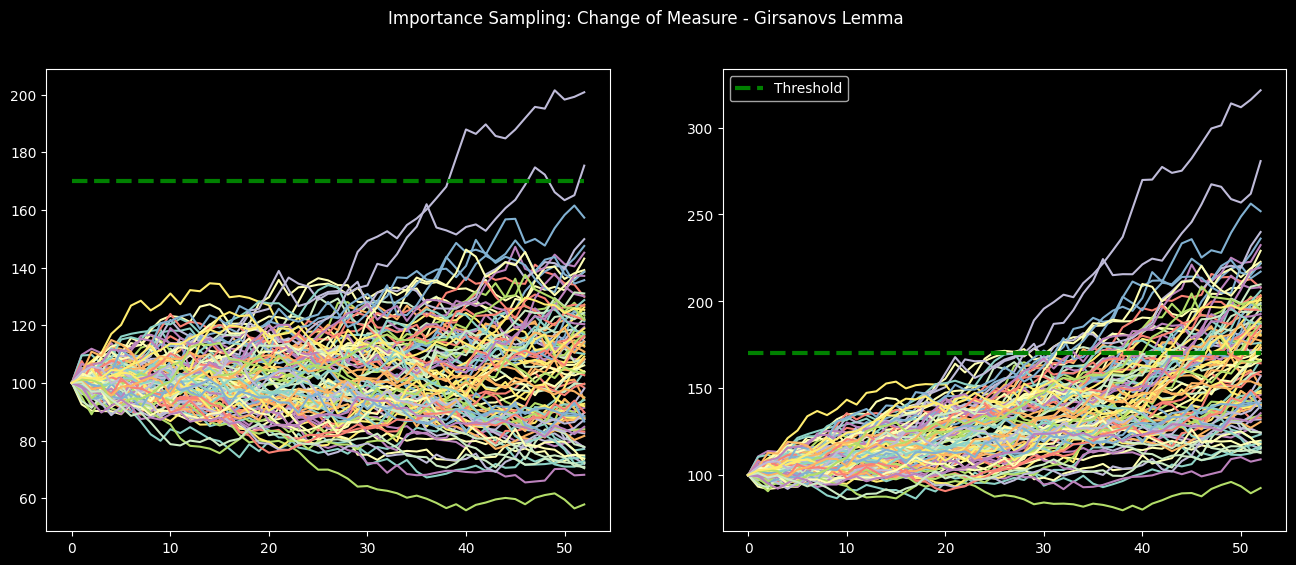

In [35]:
# Consts
M = 100
N = 52
dt = T/N
nudt = (r - 0.5*vol**2)*dt
nudt2 = (np.log(K/S0)-0.5*vol**2)*dt
volsdt = vol*np.sqrt(dt)
lnS = np.log(S0)

# MCS
Z = np.random.normal(0,1,size=(N, M)) 

delta_lnSt = nudt + volsdt*Z 
lnSt = lnS + np.cumsum(delta_lnSt, axis=0)
lnSt = np.concatenate( (np.full(shape=(1, M), fill_value=lnS), lnSt ) )

delta_lnSt2 = nudt2 + volsdt*Z 
lnSt2 = lnS + np.cumsum(delta_lnSt2, axis=0)
lnSt2 = np.concatenate( (np.full(shape=(1, M), fill_value=lnS), lnSt2 ) )

ST = np.exp(lnSt)
ST2 = np.exp(lnSt2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
fig.suptitle('Importance Sampling: Change of Measure - Girsanovs Lemma')
ax1.plot(ST)
ax1.plot([0,N],[K,K],'g--',linewidth=3, label='Threshold')

ax2.plot(ST2)
ax2.plot([0,N],[K,K],'g--',linewidth=3, label='Threshold')
plt.legend()

## Variance Minimization with correct distribution

Generally speaking, there is no a unique correct way to final the optimal $q(x)$ distribution under $dQ_0$ distribution, but an alternative way to reduce variance exists:

$min_\mu E_p[f^2(x)\frac{p(x)}{q_\mu(x)}]$

Reference: http://dx.doi.org/10.4236/jmf.2013.34045


In [46]:
M = 1000000
S0 = 100.0     
K = 170.0      
T = 1.0        
r = 0.06       
vol = 0.20    

dt = T
nudt = (r - 0.5*vol**2)*dt
nudt2 = (np.log(K/S0)-0.5*vol**2)*dt
volsdt = vol*np.sqrt(dt)

nudt, nudt2

(0.039999999999999994, 0.5106282510621704)

In [47]:
def arg_min(x):
    x_T = np.random.normal(0, 1, M)
    z = z_T(x_T,nudt,volsdt)
    return np.mean(f_0(z)**2 * p.pdf(z)/q(x).pdf(z))

In [48]:
p = sc.stats.norm(nudt,volsdt)
q = lambda mu: sc.stats.norm(mu, volsdt)
z_T = lambda x, mu, sig: mu + sig*x
f_0 = lambda z: np.exp(-r*T)*np.maximum(0, S0*np.exp(z)-K)

mu_star = sc.optimize.fmin(lambda x: arg_min(x), nudt2, disp=True)
mu_star

Optimization terminated successfully.
         Current function value: 0.012949
         Iterations: 13
         Function evaluations: 31


array([0.61913675])

In [49]:
C0_is, SE_is = [], []
for M in np.arange(100,1000+100,100):
    mu = mu_star[0]
    x = np.random.randn(M)
    z = z_T(x,mu,volsdt)
    CT = f_0(z) * p.pdf(z)/q(mu).pdf(z)
    C0 = np.mean( CT )

    sigma = np.sqrt( np.sum( (CT - C0)**2) / (M-1) )
    SE = sigma/np.sqrt(M)
    
    C0_is.append(C0)
    SE_is.append(SE)
    
C0_is = np.array(C0_is)
SE_is = np.array(SE_is)
print("Call value is ${0} with SE +/- {1}".format(np.round(C0_is,3),np.round(SE_is,3)))

Call value is $[0.066 0.08  0.08  0.078 0.088 0.079 0.077 0.08  0.079 0.079] with SE +/- [0.007 0.006 0.005 0.004 0.004 0.003 0.003 0.003 0.003 0.003]


In [53]:
C0_wo, SE_wo = [], []
for M in np.arange(100,1000+100,100):
    x = np.random.randn(M)
    z = z_T(x, nudt, volsdt)
    CT = f_0(z)
    C0 = np.mean( CT )

    sigma = np.sqrt( np.sum( (CT - C0)**2) / (M-1) )
    SE = sigma/np.sqrt(M)
    C0_wo.append(C0)
    SE_wo.append(SE)
    
C0_wo = np.array(C0_wo)
SE_wo = np.array(SE_wo)

print("Call value is ${0}\n with SE +/- {1}".format(np.round(C0_wo,3),np.round(SE_wo,3)))

Call value is $[0.    0.295 0.078 0.075 0.002 0.002 0.014 0.018 0.116 0.186]
 with SE +/- [0.    0.218 0.037 0.034 0.002 0.002 0.01  0.01  0.043 0.077]


In [51]:
SE_Ratio = SE_wo/SE_is
print("Standard Error Reduction Factor {0}".format(np.round(SE_Ratio,3)))

Standard Error Reduction Factor [16.662  4.223 16.03  19.851  4.798 30.775 19.347 11.96   5.276 13.446]


In [52]:
M = np.arange(100,1000+100,100)
prices = pd.DataFrame(np.array([M, C0_wo.round(3), C0_is.round(3), SE_wo.round(3), SE_is.round(3), SE_Ratio.round(1)]).T, 
                      columns=['Simulations','Price_wo', 'Price_is','SE_wo', 'SE_is', 'Reduction'])
print("Black Scholes Price: ", round(black_scholes,4))
prices

Black Scholes Price:  0.0789


,Simulations,Price_wo,Price_is,SE_wo,SE_is,Reduction
0,100.0,0.121,0.066,0.121,0.007,16.7
1,200.0,0.025,0.080,0.025,0.006,4.2
2,300.0,0.098,0.080,0.077,0.005,16.0
3,400.0,0.109,0.078,0.085,0.004,19.9
4,500.0,0.029,0.088,0.019,0.004,4.8
5,600.0,0.231,0.079,0.106,0.003,30.8
6,700.0,0.117,0.077,0.062,0.003,19.3
7,800.0,0.052,0.080,0.036,0.003,12.0
8,900.0,0.031,0.079,0.015,0.003,5.3
9,1000.0,0.083,0.079,0.036,0.003,13.4
